In [1]:
import os
import numpy as np
from matplotlib import pylab as plt

import pandas as pd
import math
import random
from functools import reduce
from itertools import islice
from sklearn.metrics import roc_auc_score

from scipy.stats import wilcoxon
import statistics

In [2]:
def load_master_file(path, number_of_bins=1000):
    mol_all = np.loadtxt(path, dtype="U25")  # Get master file in as numpy array

    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=range(number_of_bins), dtype=float)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], float(row[1]) - 1] = float(row[2])

    return intensities

def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint
    
    # number_of_rows to skip, e.g. headers
    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows)  # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0])  # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index=fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    return fingerprints

def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line[:-1])
    return fingerprint_legend

In [3]:
def generate_dataset(spec_path, fingerprints_path):
    spectra = load_master_file(spec_path)
    fingerprints = load_fingerprints_master(fingerprints_path)
    
    for idx, value in fingerprints.astype(bool).sum(axis=0).iteritems():
        if value < 10:
            fingerprints.drop(columns=[idx], inplace=True)
        
    train, validate, test = np.split(spectra.sample(frac=1), [int(.6*len(spectra)), int(.8*len(spectra))])
    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]

    train.sort_index(inplace=True)
    validate.sort_index(inplace=True)
    test.sort_index(inplace=True)
    train_fingerprints.sort_index(inplace=True)
    validate_fingerprints.sort_index(inplace=True)
    test_fingerprints.sort_index(inplace=True)

    return train, train_fingerprints, validate, validate_fingerprints, test, test_fingerprints

In [4]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def just_fragments_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

def just_shifts_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

def fragments_shifts_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Using TensorFlow backend.


In [5]:
def calc_peak_differences(spec):
    non_zero_peaks = list(np.where(spec>0)[0])
    peak_differences = [(abs(i-j), (spec[i]+spec[j]/2.0)) for i in non_zero_peaks for j in non_zero_peaks if i != j and j > i]
    
    return peak_differences

In [6]:
def load_shift_bins(intensities):
    shift_bins = pd.DataFrame(0.0, index = intensities.index, columns=range(intensities.shape[1]), dtype=float)
    for index, spec in enumerate(intensities.values):
        peak_differences = calc_peak_differences(spec)
        mol_name = intensities.index[index]
        for shift, average_intensity in peak_differences:
            shift_bins.at[mol_name, shift-1] += average_intensity
        shift_bins.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
    return shift_bins

In [7]:
def compute_auc(bits, true, pred):
    # Create structured array to hold statistics for each.
    dtype = [('fp_id', int), ('auc', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    
    for fp_id in range(true.shape[1]): # For every substructure
        nonzero_vals = np.count_nonzero(true[:, fp_id]) # Count number of nonzero values
        if 0 < nonzero_vals < true[:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[:, fp_id]
            fp_pred = pred[:, fp_id]
            score = roc_auc_score(fp_true, fp_pred)

            mol_stats[fp_id] = (fp_id, score)
        else:
            mol_stats[fp_id] = (fp_id, 0)
        
    print("Done")
    return mol_stats

In [8]:
def train_fragments_diff_splits(path, iteration_index):
    epochs = 100
    N,M = train.shape
    shuffle_order = np.random.permutation(N)
    path = path + "exp_{}_fragments_only_aucs.csv".format(iteration_index)
    print(train.shape)
    
    x_train_spec = np.log(train.values + 1)
    x_validate_spec = np.log(validate.values + 1)
    x_test_spec = np.log(test.values + 1)
    
    mod = just_fragments_model(x_train_spec, train_fingerprints)
    mod.fit(x_train_spec[shuffle_order,:],train_fingerprints.values[shuffle_order,:],epochs=epochs,
            validation_data=(x_validate_spec, validate_fingerprints.values),verbose=0)

    predicted = mod.predict(x_test_spec)
    stats = compute_auc(test_fingerprints.shape[1], test_fingerprints.values, predicted)

    with open(path, 'w') as f:    
        for fp_id, auc in stats:
            f.write(str(fp_id) + "," + str(auc) + "\n")

def train_shifts_diff_splits(path, iteration_index):
    epochs = 100
    N,M = train.shape
    shuffle_order = np.random.permutation(N)
    path = path + "exp_{}_shifts_only_aucs.csv".format(iteration_index)
    print(train.shape)
    
    train_shift_bins = load_shift_bins(train)
    validate_shift_bins = load_shift_bins(validate)
    test_shift_bins = load_shift_bins(test)

    x_train_shifts = np.log(train_shift_bins.values + 1)
    x_validate_shifts = np.log(validate_shift_bins.values + 1)
    x_test_shifts = np.log(test_shift_bins.values + 1)
    
    mod = just_shifts_model(x_train_shifts, train_fingerprints)
    mod.fit(x_train_shifts[shuffle_order,:],train_fingerprints.values[shuffle_order,:],epochs=epochs,
            validation_data=(x_validate_shifts, validate_fingerprints.values),verbose=0)

    predicted = mod.predict(x_test_shifts)
    stats = compute_auc(test_fingerprints.shape[1], test_fingerprints.values, predicted)

    with open(path, 'w') as f:    
        for fp_id, auc in stats:
            f.write(str(fp_id) + "," + str(auc) + "\n")

def train_fragments_and_shifts_diff_splits(path, iteration_index):
    epochs = 100
    N,M = train.shape
    shuffle_order = np.random.permutation(N)
    path = path + "exp_{}_fragments_and_shifts_aucs.csv".format(iteration_index)
    print(train.shape)
    train_shift_bins = load_shift_bins(train)
    validate_shift_bins = load_shift_bins(validate)
    test_shift_bins = load_shift_bins(test)
    
    x_train_spec = np.log(train.values + 1)
    x_validate_spec = np.log(validate.values + 1)
    x_test_spec = np.log(test.values + 1)
    x_train_shifts = np.log(train_shift_bins.values + 1)
    x_validate_shifts = np.log(validate_shift_bins.values + 1)
    x_test_shifts = np.log(test_shift_bins.values + 1)
    
    train_combined = np.concatenate((x_train_spec,x_train_shifts),axis=1) 
    validate_combined = np.concatenate((x_validate_spec,x_validate_shifts),axis=1)
    test_combined = np.concatenate((x_test_spec,x_test_shifts),axis=1)
    
    mod = fragments_shifts_model(train_combined, train_fingerprints)
    mod.fit(train_combined[shuffle_order,:],train_fingerprints.values[shuffle_order,:],epochs=epochs,
            validation_data=(validate_combined, validate_fingerprints.values),verbose=0)

    predicted = mod.predict(test_combined)
    stats = compute_auc(test_fingerprints.shape[1], test_fingerprints.values, predicted)

    with open(path, 'w') as f:
        for fp_id, auc in stats:
            f.write(str(fp_id) + "," + str(auc) + "\n")

In [9]:
spec_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"
path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\"

In [13]:
for i in range(2,10):
    print(i)
    train, train_fingerprints, validate, validate_fingerprints, test, test_fingerprints = generate_dataset(spec_path, fingerprints_path) 
    train_fragments_diff_splits(path, i)
    train_shifts_diff_splits(path, i)
    train_fragments_and_shifts_diff_splits(path, i)

1
(3462, 1000)
Done
(3462, 1000)
Done
(3462, 1000)
Done
2


KeyboardInterrupt: 

In [11]:
fingerprint_names = load_fingerprint_legend()

In [12]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort() # Arrange from smallest to highest
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue, rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []

    for pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used
        new_values.append((pvalue, rank, critical_value))
    
    max_pvalue_less_than_crit = 0.0
    max_pvalue_less_than_crit_rank = 0
    
    for pvalue, rank, critical_value in new_values:
        if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
            max_pvalue_less_than_crit = pvalue
            max_pvalue_less_than_crit_rank = rank
            
    return new_values, max_pvalue_less_than_crit_rank

In [22]:
path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\"

shift_only_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("shifts_only_aucs.csv")]
fragment_only_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("fragments_only_aucs.csv")]
combined_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("fragments_and_shifts_aucs.csv")]

shift_df = pd.DataFrame(0.0, index=shift_only_filenames, columns=range(307), dtype=float)
fragment_df = pd.DataFrame(0.0, index=fragment_only_filenames, columns=range(307), dtype=float)
combined_df = pd.DataFrame(0.0, index=combined_filenames, columns=range(307), dtype=float)

for file in shift_only_filenames:
    filepath = os.path.join(path, file + "_shifts_only_aucs.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, auc = line.split(",")
            shift_df.at[file, int(fingerprint)] = float(auc[:-1])
    
for file in fragment_only_filenames:
    filepath = os.path.join(path, file + "_fragments_only_aucs.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, auc = line.split(",")
            fragment_df.at[file, int(fingerprint)] = float(auc[:-1])
            
for file in combined_filenames:
    filepath = os.path.join(path, file + "_fragments_and_shifts_aucs.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, auc = line.split(",")
            combined_df.at[file, int(fingerprint)] = float(auc[:-1])


Overall comparison


In [23]:
combined_indexes = []
combined_means = []
combined_std = []
fragment_indexes = []
fragment_means = []
fragment_std = []
shift_indexes = []
shift_means = []
shift_std = []

for i in shift_df.columns:
    non_zeros = [score for score in shift_df[i].tolist() if score != 0]
    if len(non_zeros) > 1:
        shift_indexes.append(i)
        shift_means.append(statistics.mean(non_zeros))
        shift_std.append(statistics.stdev(non_zeros))
        
for i in fragment_df.columns:
    non_zeros = [score for score in fragment_df[i].tolist() if score != 0]
    if len(non_zeros) > 1:
        fragment_indexes.append(i)
        fragment_means.append(statistics.mean(non_zeros))
        fragment_std.append(statistics.stdev(non_zeros))

for i in combined_df.columns:
    non_zeros = [score for score in combined_df[i].tolist() if score != 0]
    if len(non_zeros) > 1:
        combined_indexes.append(i)
        combined_means.append(statistics.mean(non_zeros))
        combined_std.append(statistics.stdev(non_zeros))

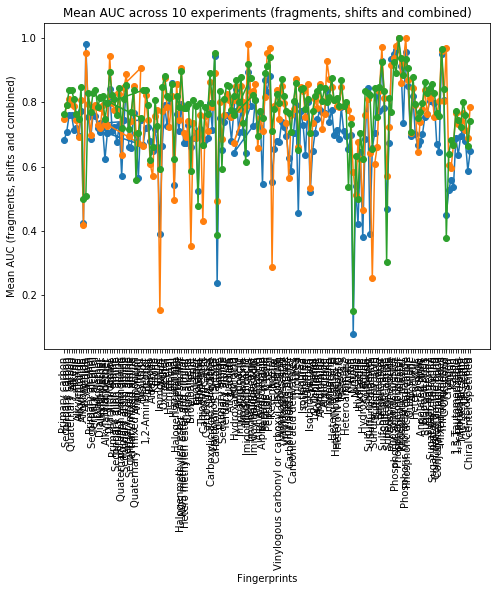

In [111]:
fingerprints = [fingerprint_names[fingerprint_index] for fingerprint_index in combined_indexes]

plt.title("Mean AUC across 10 experiments (fragments, shifts and combined)")
plt.plot(fingerprints, shift_means, '-o')
plt.plot(fingerprints, fragment_means, '-o')
plt.plot(fingerprints, combined_means, '-o')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Mean AUC (fragments, shifts and combined)")
plt.show()

Compare fragments against shifts

In [25]:
difference_filenames = ["exp_{}".format(i) for i in range(10)]
difference_df = pd.DataFrame(0.0, index=difference_filenames, columns=range(307), dtype=float)
differences = []
z_differences = []
pvalues = []

for i in combined_df.columns:
    difference_df[i] = fragment_df[i] - shift_df[i]
    difference = [difference for difference in difference_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    base_std = 0.0
    exp_std = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        base_std = statistics.stdev(shift_df[i].tolist())
        exp_std = statistics.stdev(fragment_df[i].tolist())
        
        z_score = float(abs(difference_mean))/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
        differences.append((i, difference_mean, difference_std))
        z_differences.append((i, z_score))
        t_test = wilcoxon(fragment_df[i], shift_df[i])
        pvalues.append(t_test.pvalue)

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [26]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

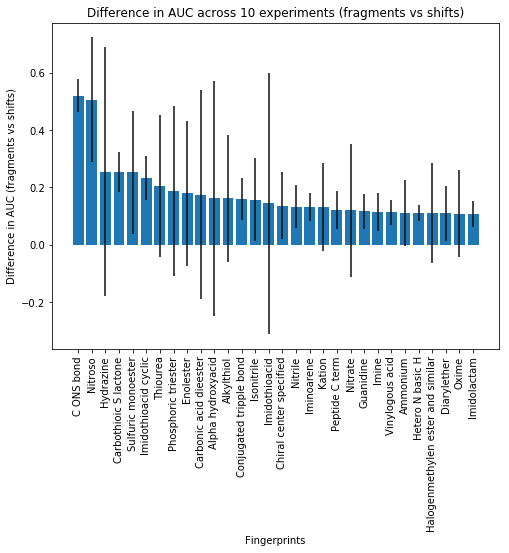

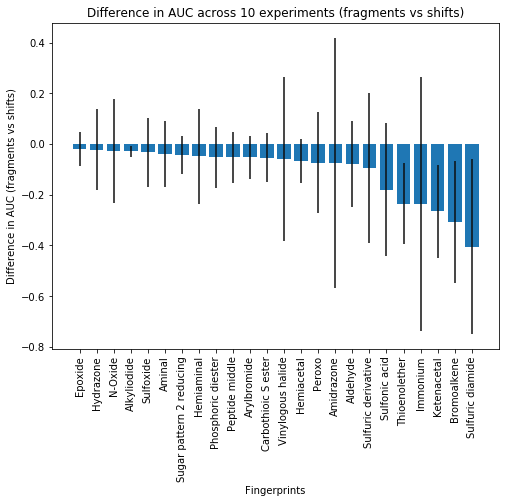

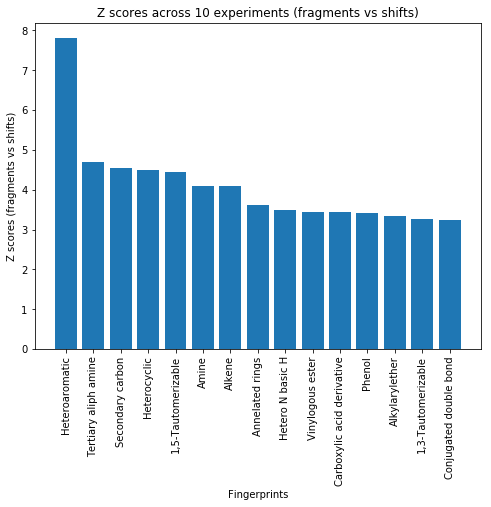

72
72


In [31]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (fragments vs shifts)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (fragments vs shifts)")
plt.show()

plt.title("Difference in AUC across 10 experiments (fragments vs shifts)")
plt.bar(fingerprints[150:], score_differences[150:], align='center', yerr=std_err[150:], error_kw=error_config)
plt.xticks(rotation=90),
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (fragments vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (fragments vs shifts)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (fragments vs shifts)")
plt.show()

pvalues = [pvalue for pvalue in pvalues if not math.isnan(pvalue)] # remove the ones that are not able to predict for both
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
print(max_pvalue_less_than_crit_rank -1)

Compare combined with fragments only

In [34]:
difference_filenames = ["exp_{}".format(i) for i in range(10)]
difference_df = pd.DataFrame(0.0, index=difference_filenames, columns=range(307), dtype=float)
differences = []
z_differences = []
pvalues = []

for i in combined_df.columns:
    difference_df[i] = combined_df[i] - fragment_df[i]
    difference = [difference for difference in difference_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    base_std = 0.0
    exp_std = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        base_std = statistics.stdev(shift_df[i].tolist())
        exp_std = statistics.stdev(fragment_df[i].tolist())
        
        z_score = float(abs(difference_mean))/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
        differences.append((i, difference_mean, difference_std))
        z_differences.append((i, z_score))
        t_test = wilcoxon(combined_df[i], fragment_df[i])
        pvalues.append(t_test.pvalue)

In [35]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

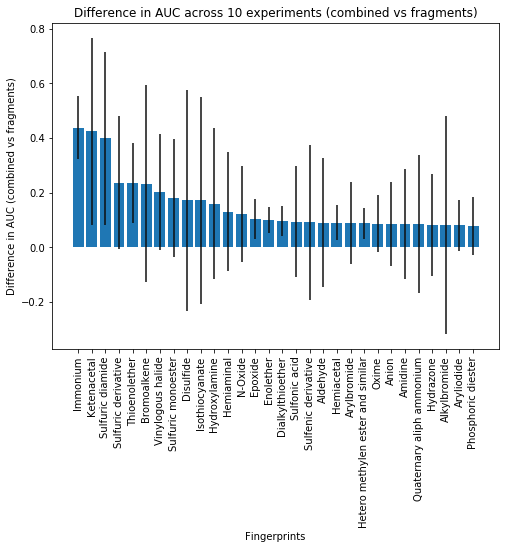

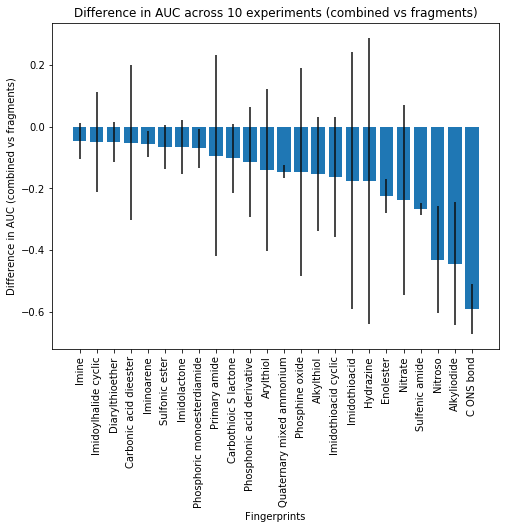

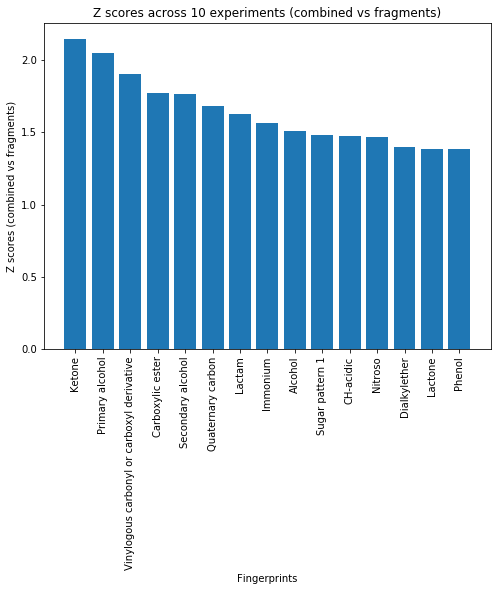

0
17


In [36]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (combined vs fragments)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs fragments)")
plt.show()

plt.title("Difference in AUC across 10 experiments (combined vs fragments)")
plt.bar(fingerprints[150:], score_differences[150:], align='center', yerr=std_err[150:], error_kw=error_config)
plt.xticks(rotation=90),
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs fragments)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs fragments)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs fragments)")
plt.show()

pvalues = [pvalue for pvalue in pvalues if not math.isnan(pvalue)] # remove the ones that are not able to predict for both
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
print(max_pvalue_less_than_crit_rank -1)

Compare combined with shifts only

In [83]:
difference_filenames = ["exp_{}".format(i) for i in range(10)]
difference_df = pd.DataFrame(0.0, index=difference_filenames, columns=range(307), dtype=float)
differences = []
z_differences = []
pvalues = []

for i in combined_df.columns:
    difference_df[i] = combined_df[i] - shift_df[i]
    difference = [difference for difference in difference_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    base_std = 0.0
    exp_std = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)
        base_std = statistics.stdev(shift_df[i].tolist())
        exp_std = statistics.stdev(fragment_df[i].tolist())
        
        z_score = float(abs(difference_mean))/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
        differences.append((i, difference_mean, difference_std))
        z_differences.append((i, z_score))
        t_test = wilcoxon(combined_df[i], shift_df[i])
        pvalues.append(t_test.pvalue)

In [84]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in differences]
z_fingerprints = [fingerprint_names[fingerprint[0]] for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

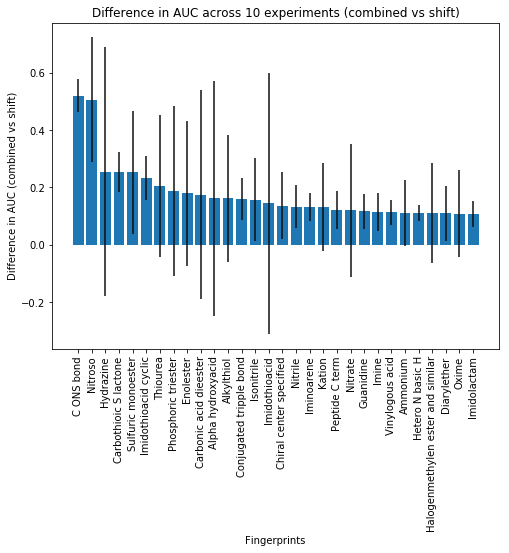

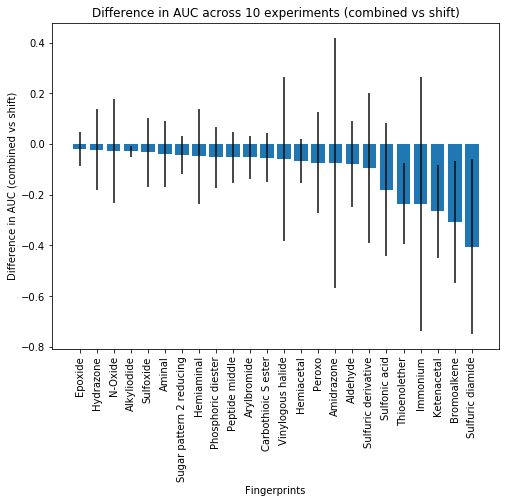

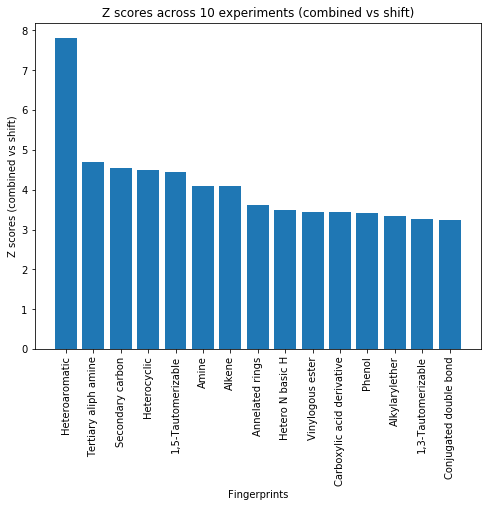

72
72


In [33]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (combined vs shift)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs shift)")
plt.show()

plt.title("Difference in AUC across 10 experiments (combined vs shift)")
plt.bar(fingerprints[150:], score_differences[150:], align='center', yerr=std_err[150:], error_kw=error_config)
plt.xticks(rotation=90),
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs shift)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs shift)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs shift)")
plt.show()

pvalues = [pvalue for pvalue in pvalues if not math.isnan(pvalue)] # remove the ones that are not able to predict for both
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
print(max_pvalue_less_than_crit_rank -1)